In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize;

In [ ]:
def RMSE(ypred,y):
    errs = ypred - y;
    return np.mean(np.sqrt(np.sum(np.power(errs,2))/len(y)));
def RMSLE(ypred,y):
    errs = np.log1p(ypred) - np.log1p(y);
    return np.mean(np.sqrt(np.sum(np.power(errs,2))/len(y)));

In [2]:
data_train_orig = pd.read_csv('train.csv',parse_dates=['date_time'],index_col='date_time')
data_test_orig = pd.read_csv('test.csv',parse_dates=['date_time'],index_col='date_time')
sample_submission = pd.read_csv('sample_submission.csv');
feature_cols = list(data_test_orig.columns);
#target_cols = ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides'];
target_cols = [col for col in data_train_orig.columns if col not in feature_cols];

data_train = data_train_orig.copy();
data_test = data_test_orig.copy();

res = data_train.index < '2010-11-1'; train_res = res; valid_res = ~res;
#train_res = ('2010-08-01' < X_train.index) & (X_train.index < '2010-11-1'); valid_res = X_train.index >= '2010-11-1';

data_valid = data_train.iloc[valid_res];
data_train = data_train.iloc[train_res];

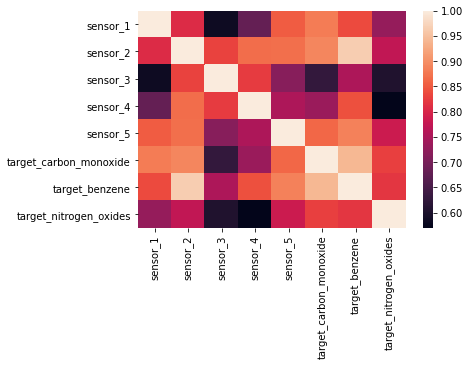

In [3]:
data_train['sensor_3'] = -data_train['sensor_3'];
sensors = ['sensor_'+str(jj) for jj in [1,2,3,4,5]];

sns.heatmap(data_train[sensors+target_cols].corr());

In [6]:
def munge(df):
    sensors_compromised = df['sensor_4'] < 650; # found that all feature data + two of the target columns are bad simultaneously
    df = df.drop(sensors_compromised.index[sensors_compromised])
    return df;
data_train = munge(data_train);
data_valid = munge(data_valid);

In [5]:
print(len(data_train));
print(len(data_valid));
print(len(data_train) + len(data_valid))
print(len(data_train_orig))

5498
1385
6883
7111


# sensor_2 is highly correlated with target_benzene. what does the relationship look like?

,sensor_2,target_benzene
sensor_2,1.000000,0.969873
target_benzene,0.969873,1.000000


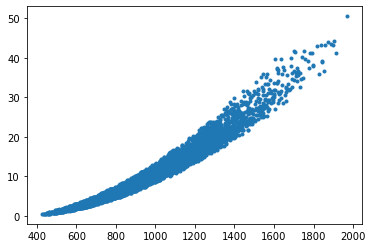

In [7]:
plt.plot(data_train['sensor_2'],data_train['target_benzene'],'.');

data_train[['sensor_2','target_benzene']].corr()

# Relationship appears monotonic, but not linear. Can we transform?

,sensor_2,benzene
sensor_2,1.000000,0.986674
benzene,0.986674,1.000000


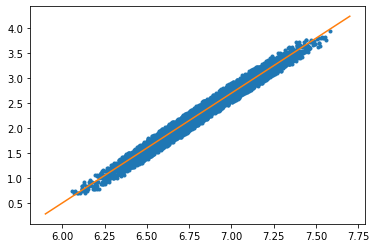

In [8]:
s1 = 0;
s2 = 1.5;
plt.plot(np.log(s1+data_train['sensor_2']),np.log(s2+data_train['target_benzene']),'.');
ff = lambda x:2.7+2.2*(x-7.);
xx = np.array([5.9,7.7]);
plt.plot(xx,ff(xx))

pd.DataFrame(np.vstack( (np.log(s1+data_train['sensor_2']),np.log(s2+data_train['target_benzene'])) ).T,columns=['sensor_2','benzene']).corr()

# After transformation, target_benzene and sensor_2 have correlation of 0.986

[1.74092374]
0.9867239476627307


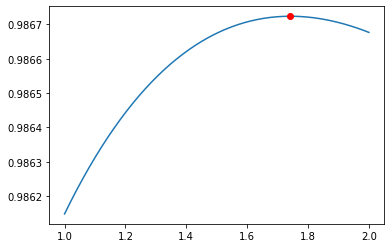

In [9]:
get_corr = lambda s:pd.DataFrame(np.vstack( (np.log(data_train['sensor_2']),np.log(s+data_train['target_benzene'])) ).T).corr().to_numpy()[0,1];

ss = np.linspace(1,2);
plt.plot(ss,[get_corr(s) for s in ss])

from scipy.optimize import minimize
res = minimize(lambda s:-get_corr(s),1.5)
plt.plot(res.x,-res.fun,'ro')
print(res.x)
print(-res.fun)

## Use a linear model to find coefficients

In [10]:
X = data_train[['sensor_2']].copy();
X = np.log(X);
X['one'] = 1;
y = data_train['target_benzene'];

X_valid = data_valid[['sensor_2']].copy();
X_valid = np.log(X_valid);
X_valid['one'] = 1;
y_valid = data_valid['target_benzene'];

In [12]:
from sklearn.linear_model import Lasso, Ridge
ss = 1.741; transform_forward = lambda x:np.log(ss+x); transform_backward = lambda x:np.exp(x)-ss;

myModel = Ridge(fit_intercept=False,alpha=0.05);
myModel.fit(X,transform_forward(y));
y_pred = transform_backward(myModel.predict(X));
y_valid_pred = transform_backward(myModel.predict(X_valid));

print('training loss   = %0.6f'%(RMSE(y_pred,y)))
print('validation loss = %0.6f'%(RMSE(y_valid_pred,y_valid)))

print(myModel.coef_)
A = myModel.coef_[0];
B = myModel.coef_[1];

def add_sensor_2_pred(df):
    df['sensor_2_pred'] = np.exp(A*np.log(df['sensor_2'])+B)-ss;
add_sensor_2_pred(data_train);
add_sensor_2_pred(data_valid);
    
pd.DataFrame( np.vstack( (data_train['sensor_2_pred'],data_train['target_benzene']) ).T ).corr()

training loss   = 1.343095
validation loss = 1.527343
[  2.13688749 -12.25172763]


,0,1
0,1.000000,0.982658
1,0.982658,1.000000


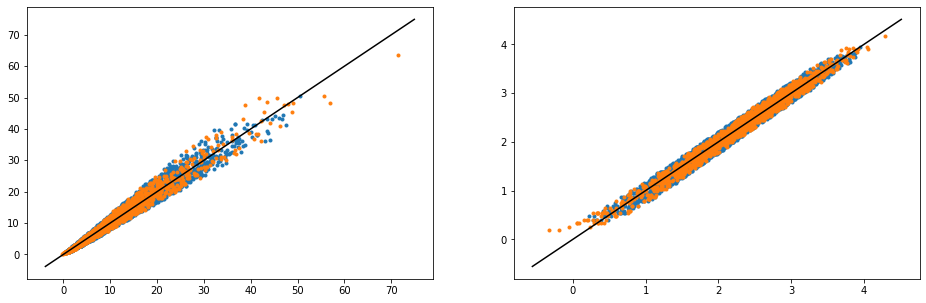

In [18]:
plt.figure(figsize=(16,5));
plt.subplot(1,2,1);
plt.plot(data_train['sensor_2_pred'],data_train['target_benzene'],'.')
plt.plot(data_valid['sensor_2_pred'],data_valid['target_benzene'],'.')
mylim = plt.gca().get_xlim();
plt.plot(mylim,mylim,'k')

plt.subplot(1,2,2);
plt.plot(np.log1p(data_train['sensor_2_pred']),np.log1p(data_train['target_benzene']),'.')
plt.plot(np.log1p(data_valid['sensor_2_pred']),np.log1p(data_valid['target_benzene']),'.')
mylim = plt.gca().get_xlim();
plt.plot(mylim,mylim,'k')

# Now sensor_1

,sensor_1,target_benzene
sensor_1,1.000000,0.862776
target_benzene,0.862776,1.000000


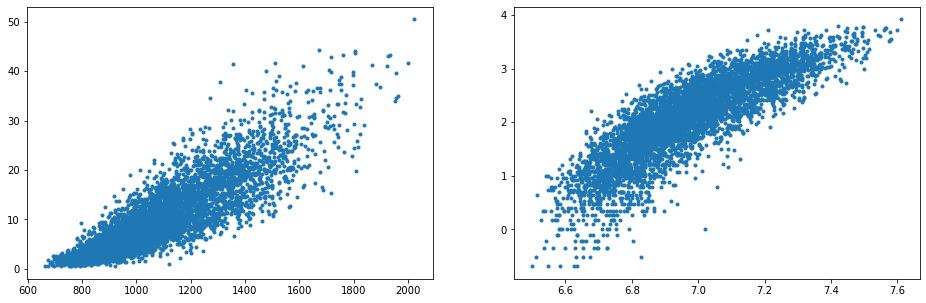

In [19]:
plt.figure(figsize=(16,5));
plt.subplot(1,2,1);
plt.plot(data_train['sensor_1'],data_train['target_benzene'],'.');

plt.subplot(1,2,2);
plt.plot(np.log(data_train['sensor_1']),np.log(data_train['target_benzene']),'.');

data_train[['sensor_1','target_benzene']].corr()

,sensor_1,benzene
sensor_1,1.000000,0.871958
benzene,0.871958,1.000000


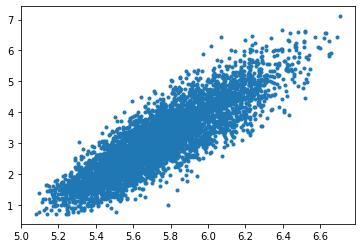

In [32]:
f_gen = lambda x,a:np.power(x,a);

xx = f_gen(data_train['sensor_1'],.25);
yy = f_gen(data_train['target_benzene'],.5);

plt.plot(xx,yy,'.');

pd.DataFrame(np.vstack( (xx,yy) ).T,columns=['sensor_1','benzene']).corr()

In [34]:
calc_corr = lambda x,y:pd.DataFrame(np.vstack((x,y)).T).corr().to_numpy()[0,1];

f_gen = lambda x,a:np.power(x,a);
loss = lambda a1,a2:1. - calc_corr(f_gen(data_train['sensor_1'],a1),f_gen(data_train['target_benzene'],a2))

res = minimize(lambda c:loss(c[0],c[1]),[.5,.5])
print(res.x)
print(loss(res.x[0],res.x[1]))
print(loss(0.25,0.5))

[0.01044946 0.46611475]
0.12788028603271284
0.12804206784460148


In [36]:
a1 = 0.25;
a2 = 0.5;

X = data_train[['sensor_1']].copy();
X = np.power(X,a1);
X['one'] = 1;
y = data_train['target_benzene'];

X_valid = data_valid[['sensor_1']].copy();
X_valid = np.log(X_valid);
X_valid['one'] = 1;
y_valid = data_valid['target_benzene'];

from sklearn.linear_model import Lasso, Ridge
transform_forward = lambda x:np.power(x,a2); transform_backward = lambda x:np.power(x,1./a2);

myModel = Ridge(fit_intercept=False,alpha=0.0001);
myModel.fit(X,transform_forward(y));
y_pred = transform_backward(myModel.predict(X));
y_valid_pred = transform_backward(myModel.predict(X_valid));


print('training loss   = %0.6f'%(RMSE(y_pred,y)))
print('validation loss = %0.6f'%(RMSE(y_valid_pred,y_valid)))


print(myModel.coef_)
A = myModel.coef_[0];
B = myModel.coef_[1];

def add_sensor_1_pred(df):
    df['sensor_1_pred'] = np.power(B+A*np.power(df['sensor_1'],a1),1./a2);
add_sensor_1_pred(data_train);
add_sensor_1_pred(data_valid);

pd.DataFrame( np.vstack( (data_train['sensor_1_pred'],data_train['target_benzene']) ).T ).corr()

training loss   = 3.648381
validation loss = 44.638909
[  3.449602  -16.6930189]


,0,1
0,1.000000,0.864345
1,0.864345,1.000000


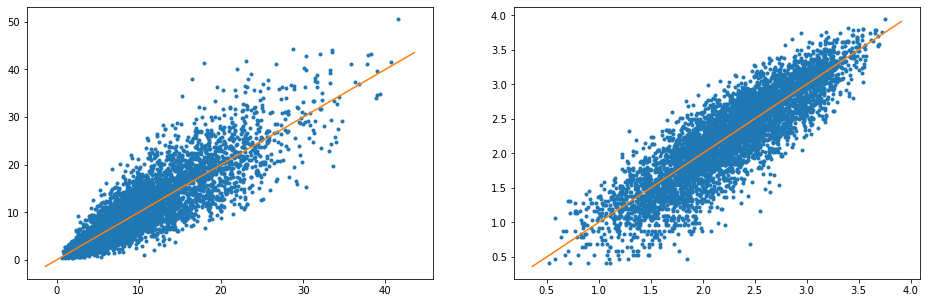

In [37]:
plt.figure(figsize=(16,5));
plt.subplot(1,2,1);
plt.plot(data_train['sensor_1_pred'],data_train['target_benzene'],'.')
mylim = plt.gca().get_xlim();
plt.plot(mylim,mylim)

plt.subplot(1,2,2);
plt.plot(np.log1p(data_train['sensor_1_pred']),np.log1p(data_train['target_benzene']),'.')
mylim = plt.gca().get_xlim();
plt.plot(mylim,mylim)

# Combining

It seems that a geometric averaging of the two predicitons yields the best results.

[0.10194277]
0.9838837784910783


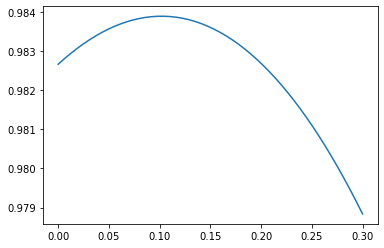

In [38]:
sensor_1_pred = data_train['sensor_1_pred'];
sensor_2_pred = data_train['sensor_2_pred'];

cc = 0.09;
combined_pred = cc*sensor_1_pred + (1.-cc)*sensor_2_pred;
#cc = .1;
#combined_pred = np.power(sensor_1_pred,cc)*np.power(sensor_2_pred,1.-cc);

make_combo = lambda cc:cc*sensor_1_pred + (1.-cc)*sensor_2_pred;
make_combo = lambda cc:np.power(sensor_1_pred,cc)*np.power(sensor_2_pred,1.-cc);
loss = lambda cc:pd.DataFrame( np.vstack((make_combo(cc),data_train['target_benzene'])).T ).corr().to_numpy()[0,1]

ccs = np.linspace(0,.3);

plt.plot(ccs,[loss(cc) for cc in ccs]);

res = minimize( lambda cc:-loss(cc),.2 );
print(res.x)
print(-res.fun)